In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score
from sklearn.datasets import load_breast_cancer
from numpy.random import default_rng
import time

## Function Definitions

In [31]:
#SIGMOID FUNCTION
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#LOGISTIC LOSS FUNCTION
def compute_loss(y, y_hat):
    m = len(y)
    eps = 1e-9
    return - (1/m) * np.sum(
        y*np.log(y_hat + eps) + (1-y)*np.log(1 - y_hat + eps)
    )

def add_bias(X):
    return np.concatenate([np.ones((X.shape[0], 1)), X], axis = 1)

def logistic_loss(w, X, y):
    z = X @ w
    p = sigmoid(z)
    eps = 1e-9
    return -np.mean(y * np.log(p + eps) + (1 - y)*np.log(1 - p + eps))

def logistic_grad(w, X, y):
    z = X @ w
    p = sigmoid(z)
    grad = (X.T @ (p - y)) / X.shape[0]
    return grad

def accuracy(w, X, y):
    p = sigmoid(X @ w)
    preds = (p >= 0.5).astype(int)
    return np.mean(preds == y)

def compute_loss_grad(w, b, Xb, yb):
    logits = Xb @ w + b
    probs = sigmoid(logits)
    probs = np.clip(probs, 1e-12, 1 - 1e-12)

    loss = -np.mean(yb * np.log(probs) + (1 - yb) * np.log(1 - probs))
    loss += 0.5 * l2_reg * np.sum(w * w)

    error = probs - yb
    grad_w = (Xb.T @ error) / len(Xb) + l2_reg * w
    grad_b = np.mean(error)

    return loss, grad_w, grad_b

def moving_average(values, window):
    if window <= 1:
        return np.array(values)
    smoothed = np.convolve(values, np.ones(window)/window, mode='valid')
    pad = np.full(window-1, smoothed[0])
    return np.concatenate([pad, smoothed])

# Vanilla Gradient Descent

In [32]:
#LOAD AND CLEAN DATA
df = pd.read_csv("data.csv")

cols_to_drop = [c for c in ["id", "Unnamed: 32"] if c in df.columns]
df = df.drop(cols_to_drop, axis=1)

df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [33]:
X = df.drop("diagnosis", axis=1).values
y = df["diagnosis"].values.reshape(-1, 1)

#TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# STANDARDIZE FEATURES
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

m, n = X_train.shape
W = np.zeros((n, 1))
b = 0

In [34]:
# GRADIENT DESCENT WITH METRICS TRACKING
learning_rate = 0.01
iterations = 2000

losses = []
smooth_losses = []
accuracy_list = []
grad_norms = []

window = 10  # smoothing window

for i in range(iterations):

    # forward pass
    z = np.dot(X_train, W) + b
    y_hat = sigmoid(z)

    # loss
    loss = compute_loss(y_train, y_hat)

    # gradients
    dw = (1/m) * np.dot(X_train.T, (y_hat - y_train))
    db = (1/m) * np.sum(y_hat - y_train)

    # gradient norm
    grad_norm = np.sqrt(np.sum(dw**2) + db**2)

    # update
    W -= learning_rate * dw
    b -= learning_rate * db

    # metrics
    losses.append(loss)
    grad_norms.append(grad_norm)

    if i >= window:
        smooth_losses.append(np.mean(losses[-window:]))
    else:
        smooth_losses.append(loss)

    preds = (y_hat >= 0.5).astype(int)
    acc = np.mean(preds == y_train)
    accuracy_list.append(acc)

### Visualizations

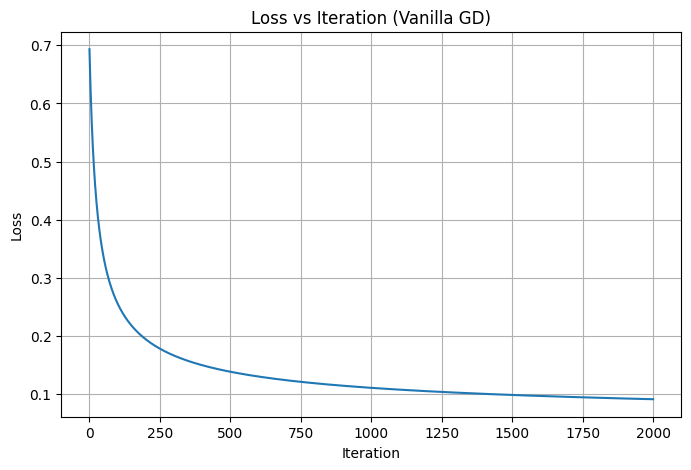

In [35]:
#PLOT: LOSS vs ITERATION
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.title("Loss vs Iteration (Vanilla GD)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

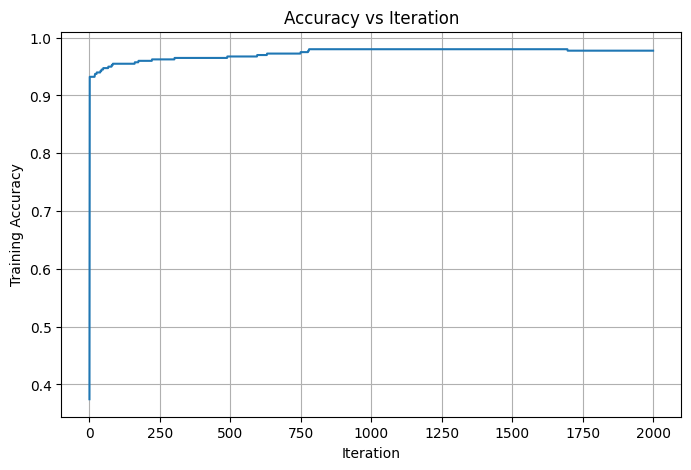

In [36]:
#PLOT: ACCURACY vs ITERATION
plt.figure(figsize=(8,5))
plt.plot(accuracy_list)
plt.title("Accuracy vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

### Results

In [37]:
# TRAIN  METRICS SUMMARY
print("Final Train Loss:", losses[-1])
print("Final Train Accuracy:", accuracy_list[-1])
print("Final Gradient Norm:", grad_norms[-1])
print("Iterations:", iterations)

Final Train Loss: 0.09166444875738938
Final Train Accuracy: 0.9773869346733668
Final Gradient Norm: 0.034421434550831936
Iterations: 2000


In [38]:
# TEST SET METRICS

z_test = np.dot(X_test, W) + b
y_hat_test = sigmoid(z_test)

test_loss = compute_loss(y_test, y_hat_test)

y_pred_test = (y_hat_test >= 0.5).astype(int)
test_accuracy = np.mean(y_pred_test == y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.06823569124618833
Test Accuracy: 0.9941520467836257


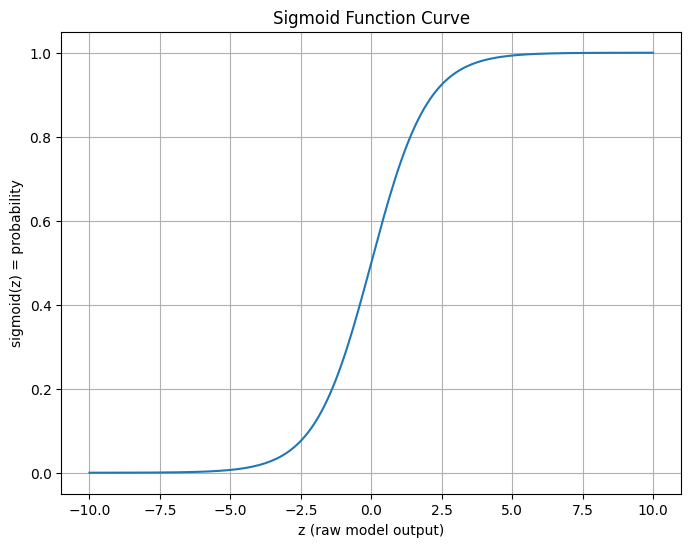

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Range of z values
z = np.linspace(-10, 10, 200)

# Compute sigmoid values
s = sigmoid(z)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(z, s)
plt.title("Sigmoid Function Curve")
plt.xlabel("z (raw model output)")
plt.ylabel("sigmoid(z) = probability")
plt.grid(True)
plt.show()

## Gradient Descent with Momentum

In [40]:
X_2 = df.drop("diagnosis", axis = 1).values
y_2 = df["diagnosis"].values.reshape(-1, 1)

scaler_2 = StandardScaler()
X_2 = scaler_2.fit_transform(X)

X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(X_2, y_2, test_size = 0.3, random_state = 42)
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_temp_2, y_temp_2, test_size = 0.5, random_state = 42)

X_train_2_b = add_bias(X_train_2)
X_val_2_b = add_bias(X_val_2)
X_test_2_b = add_bias(X_test_2)

In [41]:
# GD with Momentum
def gd_momentum(X_train, y_train, X_val, y_val, lr = 0.01, beta = 0.9, max_iters = 400):
    start = time.time()
    
    n_features = X_train.shape[1]
    w = np.zeros(n_features)
    v = np.zeros_like(w)
    
    train_losses = []
    grad_norms = []
    train_accs = []
    val_accs = []
    
    for t in range(max_iters):
        grad = logistic_grad(w, X_train, y_train)
        
        v = beta * v + lr * grad
        w = w - v
        
        loss_t = logistic_loss(w, X_train, y_train)
        grad_norm_t = np.linalg.norm(grad)
        train_acc_t = accuracy(w, X_train, y_train)
        val_acc_t = accuracy(w, X_val, y_val)
        
        train_losses.append(loss_t)
        grad_norms.append(grad_norm_t)
        train_accs.append(train_acc_t)
        val_accs.append(val_acc_t)
    
    runtime = time.time() - start
    
    return w, train_losses, grad_norms, train_accs, val_accs, runtime

### Results

In [42]:
# Running Optimization
y_train_2_vec = y_train_2.ravel()
y_val_2_vec = y_val_2.ravel()
y_test_2_vec = y_test_2.ravel()

w_momentum, losses_m, gradnorms_m, train_accs_m, val_accs_m, runtime_m = gd_momentum(
    X_train_2_b, y_train_2_vec, X_val_2_b, y_val_2_vec, lr = 0.01, beta = 0.9, max_iters = 400)

train_loss_2 = logistic_loss(w_momentum, X_train_2_b, y_train_2_vec)
val_loss_2   = logistic_loss(w_momentum, X_val_2_b, y_val_2_vec)
test_loss_2  = logistic_loss(w_momentum, X_test_2_b, y_test_2_vec)

train_acc_2 = accuracy(w_momentum, X_train_2_b, y_train_2_vec)
val_acc_2 = accuracy(w_momentum, X_val_2_b, y_val_2_vec)
test_acc_2 = accuracy(w_momentum, X_test_2_b, y_test_2_vec)

print("Train Loss:", train_loss_2)
print("Val Loss:", val_loss_2)
print("Test Loss:", test_loss_2)
print()
print("Train Acc:", train_acc_2)
print("Val Acc:", val_acc_2)
print("Test Acc:", test_acc_2)
print("Runtime:", runtime_m)

Train Loss: 0.07675283436833735
Val Loss: 0.06650924731321707
Test Loss: 0.04515980251771207

Train Acc: 0.9849246231155779
Val Acc: 0.9882352941176471
Test Acc: 0.9883720930232558
Runtime: 0.02972102165222168


### Visualizations

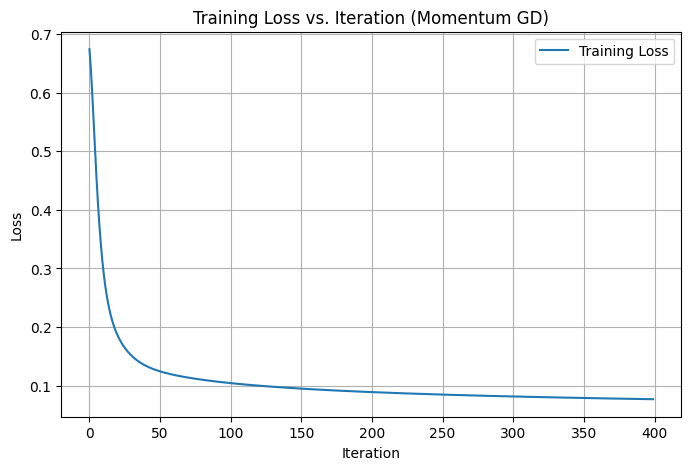

In [43]:
# Training Loos vs. Iteration Graph
plt.figure(figsize = (8,5))
plt.plot(losses_m, label = "Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss vs. Iteration (Momentum GD)")
plt.grid(True)
plt.legend()
plt.show()

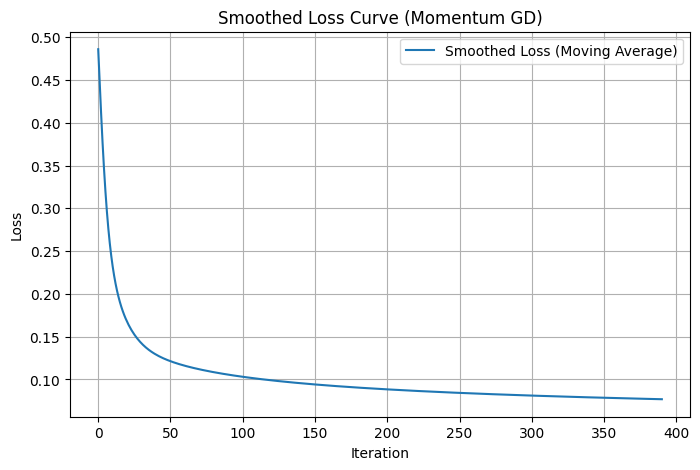

In [44]:
# Smoothed Loss Curve Graph
window = 10
smoothed_loss = np.convolve(losses_m, np.ones(window) / window, mode = 'valid')

plt.figure(figsize = (8,5))
plt.plot(smoothed_loss, label = "Smoothed Loss (Moving Average)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Smoothed Loss Curve (Momentum GD)")
plt.grid(True)
plt.legend()
plt.show()

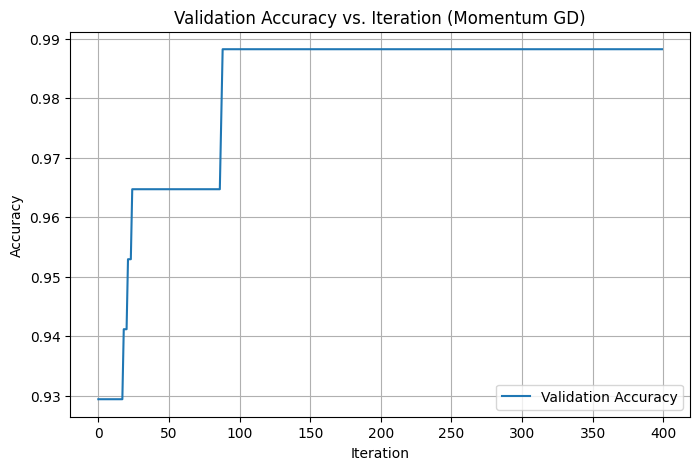

In [45]:
# Validation Accuracy vs. Iteration
plt.figure(figsize=(8,5))
plt.plot(val_accs_m, label = "Validation Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs. Iteration (Momentum GD)")
plt.grid(True)
plt.legend()
plt.show()

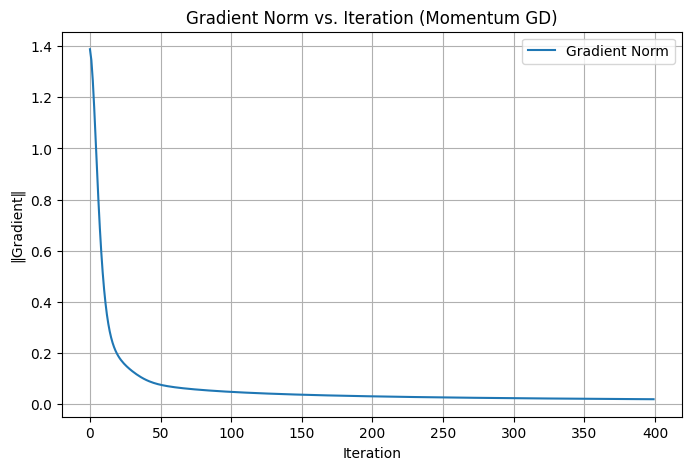

In [46]:
# Gradient Norm vs. Iteration
plt.figure(figsize = (8,5))
plt.plot(gradnorms_m, label = "Gradient Norm")
plt.xlabel("Iteration")
plt.ylabel("‖Gradient‖")
plt.title("Gradient Norm vs. Iteration (Momentum GD)")
plt.grid(True)
plt.legend()
plt.show()

## SGD

In [47]:
#Hyperparameters
learning_rate = 0.01
batch_size = 32
n_epochs = 30
l2_reg = 1e-4
moving_avg_window = 15
tolerance = 1e-8
random_seed = 42

np.random.seed(random_seed)

X_3 = df.drop("diagnosis", axis = 1).values
y_3 = df["diagnosis"].values.reshape(-1, 1)

X_train_val_3, X_test_3, y_train_val_3, y_test_3 = train_test_split(
    X_3, y_3, test_size = 0.2, random_state = random_seed, stratify = y_3)

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(
    X_train_val_3, y_train_val_3, test_size = 0.25, random_state = random_seed, stratify = y_train_val_3
)

# Standardize
scaler_3 = StandardScaler().fit(X_train_3)
X_train_3 = scaler.transform(X_train_3)
X_val_3 = scaler.transform(X_val_3)
X_test_3 = scaler.transform(X_test_3)

n_samples, n_features = X_train_3.shape

w = np.zeros(n_features)
b = 0.0

train_loss = []
grad_norms = []
val_acc_history = []
iters_at_eval = []

iterations = 0
gradient_evals = 0
prev_loss = None
convergence_iter = None

In [48]:
#training sgd
y_train_3_vec = y_train_3.ravel()
y_val_3_vec = y_val_3.ravel()

start = time.time()

for epoch in range(n_epochs):

    perm = np.random.permutation(n_samples)
    X_train_3 = X_train_3[perm]
    y_train_3_vec = y_train_3_vec[perm]

    for i in range(0, n_samples, batch_size):

        Xb_3 = X_train_3[i:i + batch_size]
        yb_3 = y_train_3_vec[i:i + batch_size]

        loss, grad_w, grad_b = compute_loss_grad(w, b, Xb_3, yb_3)
        gradient_evals += 1

        grad_norm = np.sqrt(np.sum(grad_w ** 2) + grad_b ** 2)
        grad_norms.append(grad_norm)

        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        train_loss.append(loss)
        iterations += 1

        if prev_loss is not None and abs(prev_loss - loss) < tolerance:
            convergence_iter = iterations
        prev_loss = loss

    val_probs = sigmoid(X_val_3 @ w + b)
    val_preds = (val_probs >= 0.5).astype(int)
    val_acc_history.append(accuracy_score(y_val_3_vec, val_preds))
    iters_at_eval.append(iterations)

runtime = time.time() - start

### Results + Visualizations


------ SGD METRICS ------
Train Loss: 1.6481457020272714
Val Loss: 0.16370029145236156
Test Loss: 0.15138141586233197
Train Acc: 0.5073313782991202
Val Acc: 0.9649122807017544
Test Acc: 0.9649122807017544
Iterations: 330
Gradient Evaluations: 330
Runtime Seconds: 0.020221948623657227


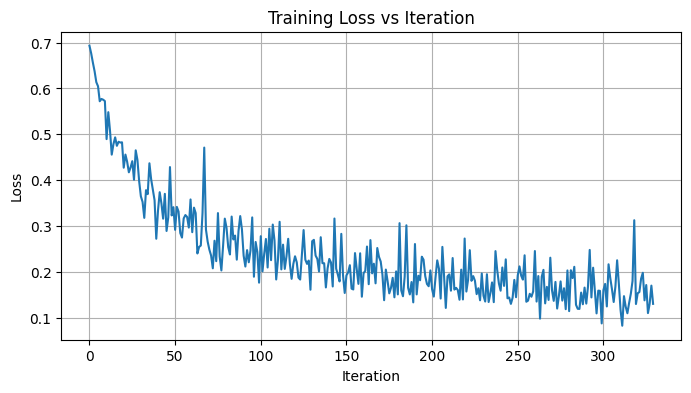

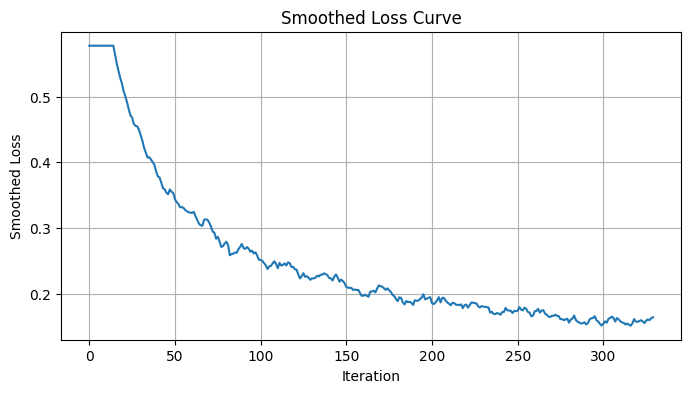

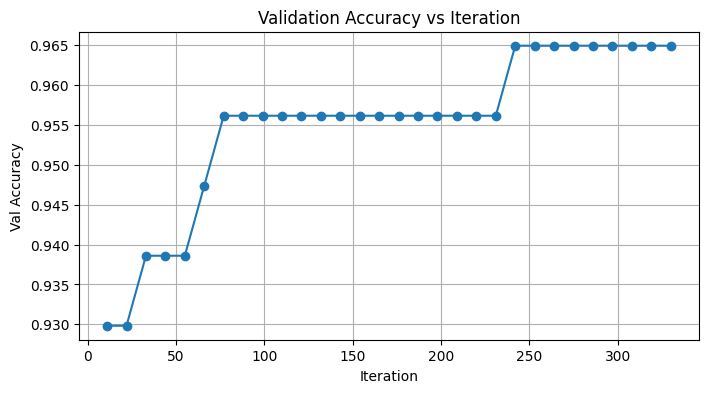

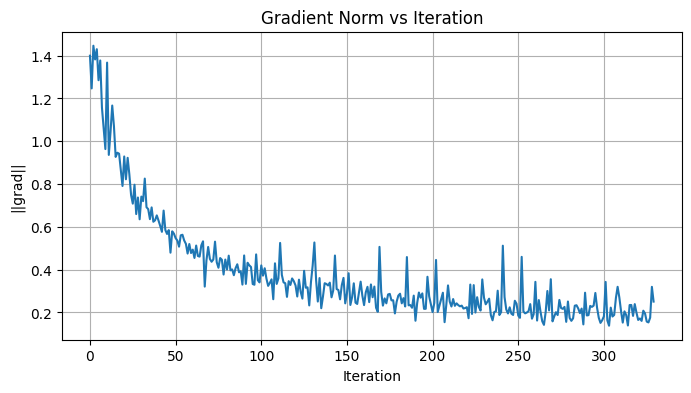

In [49]:
#final evaluation
train_probs_3 = sigmoid(X_train_3 @ w + b)
val_probs_3 = sigmoid(X_val_3 @ w + b)
test_probs_3 = sigmoid(X_test_3 @ w + b)

summary = {
    "Train Loss": log_loss(y_train_3, train_probs_3),
    "Val Loss":   log_loss(y_val_3, val_probs_3),
    "Test Loss":  log_loss(y_test_3, test_probs_3),
    "Train Acc":  accuracy_score(y_train_3, (train_probs_3 >= 0.5)),
    "Val Acc":    accuracy_score(y_val_3, (val_probs_3 >= 0.5)),
    "Test Acc":   accuracy_score(y_test_3, (test_probs_3 >= 0.5)),
    "Iterations": iterations,
    "Gradient Evaluations": gradient_evals,
    "Runtime Seconds": runtime,
}

print("\n------ SGD METRICS ------")
for k,v in summary.items():
    print(f"{k}: {v}")

#plot
#raw loss curve
plt.figure(figsize = (8,4))
plt.plot(train_loss)
plt.title("Training Loss vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

#smoothed loss curve
smooth = moving_average(train_loss, moving_avg_window)
plt.figure(figsize = (8,4))
plt.plot(smooth)
plt.title("Smoothed Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Smoothed Loss")
plt.grid(True)
plt.show()

#validation accuracy
plt.figure(figsize = (8,4))
plt.plot(iters_at_eval, val_acc_history, marker = 'o')
plt.title("Validation Accuracy vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Val Accuracy")
plt.grid(True)
plt.show()

#gradient norm diagnostic
plt.figure(figsize = (8,4))
plt.plot(grad_norms)
plt.title("Gradient Norm vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("||grad||")
plt.grid(True)
plt.show()

## SPSA

In [50]:
def spsa_logreg(Xtr, ytr, Xva, yva, iters = 350, batch_size = 64, a = 0.12, c = 0.10, A = 50.0, alpha = 0.602, gamma = 0.101,
    l2 = 1e-4, seed = 1):
    rng = default_rng(seed)
    n, d = Xtr.shape
    theta = np.zeros(d)

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    grad_norm_hist, smooth_loss_hist = [], []

    obj_evals = 0
    t0 = time.time()

    # initial loss (full train/val) for reporting
    init_train_loss = logistic_loss(theta, Xtr, ytr); obj_evals += 1
    init_val_loss   = logistic_loss(theta, Xva, yva); obj_evals += 1

    smooth = init_train_loss
    beta = 0.95  # EMA smoothing factor

    for k in range(iters):
        ak = a / ((A + k + 1) ** alpha)
        ck = c / ((k + 1) ** gamma)

        # mini-batch (without replacement within the batch)
        bsz = min(batch_size, n)
        idx = rng.choice(n, size=bsz, replace=False)
        Xb, yb = Xtr[idx], ytr[idx]

        # Δk ∈ {-1, +1}^d
        delta = rng.choice([-1.0, 1.0], size=d)

        # two function evaluations on the SAME mini-batch
        L_plus  = logistic_loss(theta + ck * delta, Xb, yb); obj_evals += 1
        L_minus = logistic_loss(theta - ck * delta, Xb, yb); obj_evals += 1

        # SPSA gradient estimate (for ±1, Δ^{-1} = Δ)
        ghat = (L_plus - L_minus) / (2.0 * ck) * delta

        # parameter update
        theta = theta - ak * ghat

        # full-set metrics each iteration
        tr_loss = logistic_loss(theta, Xtr, ytr)
        va_loss = logistic_loss(theta, Xva, yva)
        tr_acc  = accuracy(theta, Xtr, ytr)
        va_acc  = accuracy(theta, Xva, yva)

        train_loss_hist.append(tr_loss)
        val_loss_hist.append(va_loss)
        train_acc_hist.append(tr_acc)
        val_acc_hist.append(va_acc)

        grad_norm_hist.append(float(np.linalg.norm(ghat)))

        smooth = beta * smooth + (1 - beta) * tr_loss
        smooth_loss_hist.append(smooth)

    runtime = time.time() - t0

    return {
        "theta": theta,
        "train_loss": np.array(train_loss_hist),
        "val_loss": np.array(val_loss_hist),
        "train_acc": np.array(train_acc_hist),
        "val_acc": np.array(val_acc_hist),
        "grad_norm": np.array(grad_norm_hist),
        "smooth_loss": np.array(smooth_loss_hist),
        "runtime": runtime,
        "obj_evals": obj_evals,
        "init_train_loss": init_train_loss,
        "init_val_loss": init_val_loss,
    }

In [51]:
# target: diagnosis (M=1, B=0)
y_4 = (df["diagnosis"].astype(str).str.strip() == "M").astype(int).values
X_4 = df.drop(columns=["diagnosis"]).values.astype(float)

# train/val/test = 70/15/15 (stratified)
X_train_4, X_tmp_4, y_train_4, y_tmp_4 = train_test_split(X_4, y_4, test_size = 0.30, random_state = 42, stratify = y_4)
X_val_4, X_test_4, y_val_4, y_test_4 = train_test_split(
    X_tmp_4, y_tmp_4, test_size = 0.50, random_state = 42, stratify = y_tmp_4)

# standardize features using train stats only
scaler_4 = StandardScaler()
Xtr = add_bias(scaler.fit_transform(X_train_4))
Xva = add_bias(scaler.transform(X_val_4))
Xte = add_bias(scaler.transform(X_test_4))

# run SPSA
res = spsa_logreg(Xtr, y_train_4, Xva, y_val_4, iters = 350, batch_size = 64,
    a = 0.12, c = 0.10, A = 50, alpha = 0.602, gamma = 0.101, l2 = 1e-4, seed = 1)

theta = res["theta"]

# test metrics (final unbiased evaluation)
test_loss_4 = logistic_loss(theta, Xte, y_test_4)
test_acc_4  = accuracy(theta, Xte, y_test_4)

# iterations to 95% improvement (train loss)
init = res["init_train_loss"]
best = res["train_loss"].min()
target = init - 0.95 * (init - best)
iters_to_95 = int(np.argmax(res["train_loss"] <= target) + 1) if np.any(res["train_loss"] <= target) else None

### Results

In [52]:
print("\n===== Final Results (SPSA Logistic Regression) =====")
print(f"Final Train Loss (objective): {res['train_loss'][-1]:.4f}")
print(f"Final Val Loss:              {res['val_loss'][-1]:.4f}")
print(f"Final Test Loss:             {test_loss_4:.4f}")
print(f"Final Train Acc:             {res['train_acc'][-1]:.4f}")
print(f"Final Val Acc:               {res['val_acc'][-1]:.4f}")
print(f"Final Test Acc:              {test_acc_4:.4f}")

print("\nOptimization Efficiency:")
print(f"Iterations run:              {len(res['train_loss'])}")
print(f"Iters to 95% improvement:    {iters_to_95}")
print(f"Objective evaluations:       {res['obj_evals']}  (≈2 per iter + init)")
print(f"Runtime (seconds):           {res['runtime']:.2f}")


===== Final Results (SPSA Logistic Regression) =====
Final Train Loss (objective): 0.3893
Final Val Loss:              0.3880
Final Test Loss:             0.3935
Final Train Acc:             1.0000
Final Val Acc:               1.0000
Final Test Acc:              1.0000

Optimization Efficiency:
Iterations run:              350
Iters to 95% improvement:    312
Objective evaluations:       702  (≈2 per iter + init)
Runtime (seconds):           0.05


### Visualizations

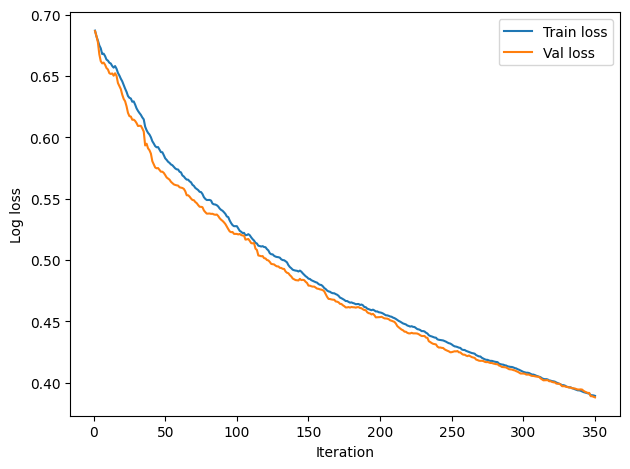

In [53]:
iters_axis = np.arange(1, len(res["train_loss"]) + 1)

# 1) Train/Val loss
plt.figure()
plt.plot(iters_axis, res["train_loss"], label = "Train loss")
plt.plot(iters_axis, res["val_loss"], label = "Val loss")
plt.xlabel("Iteration")
plt.ylabel("Log loss")
plt.legend()
plt.tight_layout()
plt.show()

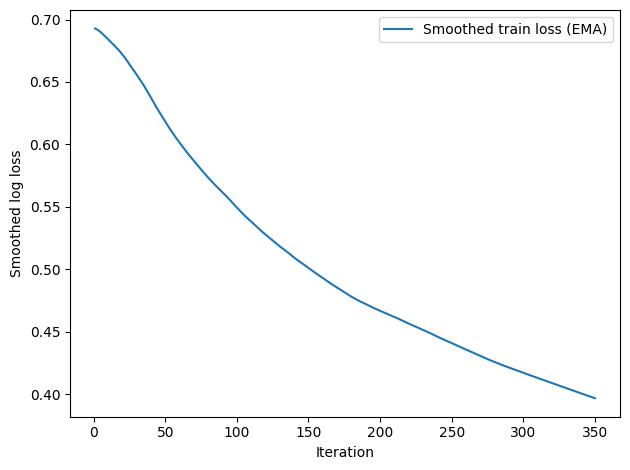

In [54]:
# 2) Smoothed train loss
plt.figure()
plt.plot(iters_axis, res["smooth_loss"], label = "Smoothed train loss (EMA)")
plt.xlabel("Iteration")
plt.ylabel("Smoothed log loss")
plt.legend()
plt.tight_layout()
plt.show()

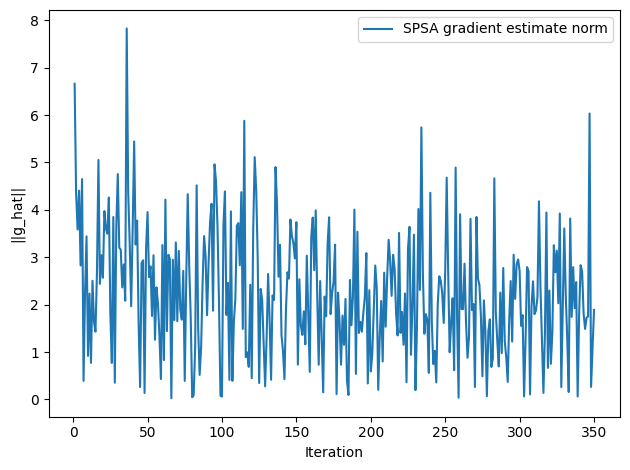

In [55]:
# 3) Gradient norm
plt.figure()
plt.plot(iters_axis, res["grad_norm"], label = "SPSA gradient estimate norm")
plt.xlabel("Iteration")
plt.ylabel("||g_hat||")
plt.legend()
plt.tight_layout()
plt.show()

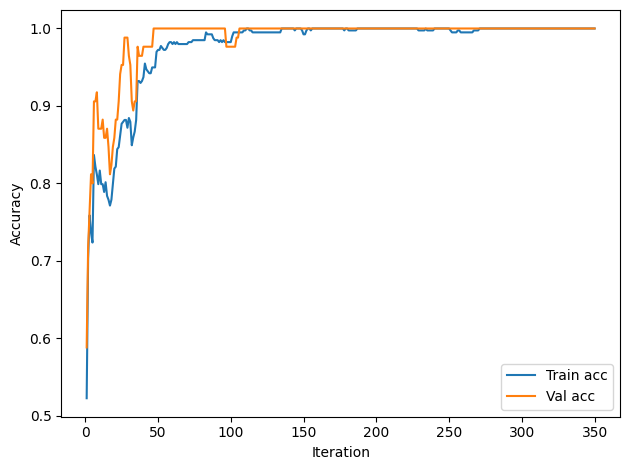

In [56]:
# 4) Train/Val accuracy
plt.figure()
plt.plot(iters_axis, res["train_acc"], label = "Train acc")
plt.plot(iters_axis, res["val_acc"], label = "Val acc")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()